<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

#cGAN tutorial
Code based on https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# TL;DR

1. In this lab scenario you will train your own cGAN model on a MNIST dataset i.e. a network generating a selected fake hand-written digit.
2. You will learn how to train the network using the adversarial objective and the "log-D" trick.
3. Finally you will understand how the generator works by performing an interpolation between two randomly generated images.

# Problem definition

The objective is to train a neural network that accepts a fixed-size random tensor and a class label as an input and outputs a counterfeit hand-written image mimicking MNIST datapoints.  


#  cGAN architecture
We will train an network based on [cGAN](https://arxiv.org/pdf/1411.1784.pdf) and [DCGAN](https://arxiv.org/abs/1511.06434).

The network consists of two parts:
* Discriminator, which accepts a datapoint (real or fake)
$x$ as well as a class label $y$ as an input and outputs the conditional probability $D(x|y)$ of the input image being a real image of class $y$.
* Generator, which accepts z fixed-size sample from the gaussian distribution $z$ as well as a random class label $y$ as an input and outputs a sample from the conditional distribution $G(z|y)$.

![](https://drive.google.com/uc?export=view&id=12qRdmfkO-dvapBVwoZjOpLVd_OdJdvtQ)

Image source: https://arxiv.org/pdf/1411.1784.pdf

cGAN is trained using the adversarial objective:
1. In the first step weights of the Discriminator are trained similarly to a binary classification:
    1. A batch of real images with corresponding class labels and training objective (1 meaning <b>REAL</b> image) is prepared and put through the Discriminator. The real loss is calculated.
    2. A batch of samples from the gaussian distribution with sample of fake labels amd training objective (0 meaning <b> FAKE </b> image) is prepared and put through the Generator and then the Discriminator. The fake loss is calculated.
    3. The final loss is calculated as the average between the real loss and the fake loss and used for training of the Discriminator parameters.
2. In the second step weights of the Generator are trained using the ["log-D" trick](https://arxiv.org/pdf/2009.00169v1.pdf):
    1. A batch of samples from the gaussian distribution with sample of fake labels and training objective (1 meaning <b> FAKE REAL </b> image) is prepared and put through the Generator and then the Discriminator. The fake real loss is calculated.
    2. The fake real loss used for training of the Generator parameters.

Some technical remarks:
1. Image class labels are inserted as 1-dimentional tensors (with integers 0-9) and passed through the [Pytorch Embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) to construct embeddings.
2. Image class embeddings are concatenated with images / samples from the gaussian distribution channelwise.
3. In the first step of adversarial training half of the batch are real images and half of the batch are fake images.


# Tasks

1. Read the code.
2. Run the pipeline, verify that:
    1. The generator creates decent counterfeit images.
    2. The quality of generated images improves over time.

3. Modify the code to perform interpolation between two sample images of the same class:
    1. Use the generator to obtain two images
      based on two sample tensors $z_1, z_2$.
    2. Generate a sequence of 50 images
      based on the segment with endpoints $z_1, z_2$.
    3. Visualize the "transition" of the sequence.

4. Modify the code to check how the "transition" between two samples change over the training time.



In [1]:
# Batch size during training
batch_size = 128

# Size of z latent vector (i.e. size of generator input)
nz = 98

# Number of training epochs
num_epochs = 10

In [2]:
import os

from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms  # type: ignore
import torchvision.utils as vutils  # type: ignore
from matplotlib.image import AxesImage
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST  # type: ignore
from tqdm import tqdm

torch.manual_seed(0)
np.random.seed(0)

In [3]:
# Decide which device we want to run on.
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


## Dataset and dataloader

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
)
dataset = MNIST(os.getcwd(), transform=transform, download=True)
# dataset = FashionMNIST(os.getcwd(), transform=transform, download=True)

In [5]:
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True
)

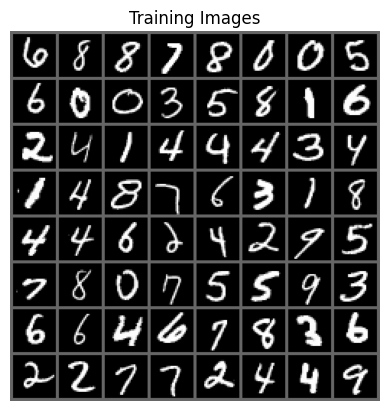

In [6]:
def plot_images(image_batch: torch.Tensor, title: str, scale: float=0.6) -> AxesImage:
    """Show a batch of images as a grid."""
    n_images = len(image_batch)
    n_columns = int(np.ceil(np.sqrt(n_images)))
    n_rows = int(np.ceil(n_images / n_columns))
    plt.figure(figsize=(n_columns * scale, n_rows * scale))
    plt.axis("off")
    plt.title(title)
    return plt.imshow(
        np.transpose(
            vutils.make_grid(
                image_batch, nrow=n_columns, padding=2, pad_value=0.4, normalize=True
            ).cpu(),
            (1, 2, 0),
        )
    )

# Plot some training images.
real_image_batch, real_label_batch = next(iter(dataloader))
plot_images(real_image_batch[:64], "Training Images")

In [7]:
# Sanity check: look at basic dataset statistics.
print(
    real_image_batch.shape,
    real_image_batch.min().item(),
    real_image_batch.max().item(),
)
print(
    real_label_batch.shape,
    real_label_batch.min().item(),
    real_label_batch.max().item(),
)

torch.Size([128, 1, 28, 28]) -1.0 1.0
torch.Size([128]) 0 9


## Generator

In [8]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.label_embedding = nn.Embedding(10, 49)
        self.linear = nn.Linear(49, 49)
        self.upconvolutions = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=nz // 49 + 1,
                out_channels=64,
                kernel_size=5,
                stride=2,
                padding=0,
                bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=32,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                in_channels=32,
                out_channels=32,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                in_channels=32,
                out_channels=16,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                in_channels=16,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=0,
                bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
        )
        self.convolutions = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(3, 3),
                padding=1,
                stride=1,
                bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=1,
                kernel_size=(3, 3),
                padding=1,
                stride=1,
                bias=False),
            nn.Tanh(),
        )

    def forward(self, z: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
          Args:
            z: latent vector, shape (B, nz, 1, 1), where B is batch size.
            y: label, as an integer between 0 and n_classes - 1, shape (B, 1).

          Returns: image of shape (batch_size, 1, 28, 28).
        """
        y = self.label_embedding(y).squeeze()  # (B, 49)
        y = self.linear(y)  # (B, 49)
        y = F.relu(y)

        z = z.view(-1, nz // 49, 7, 7)  # (B, nz // 49, 7, 7)
        y = y.view(-1, 1, 7, 7)  # (B, 1, 7, 7)
        x = torch.cat([z, y], dim=1)

        x = self.upconvolutions(x)
        x = self.convolutions(x)
        return x

torch.Size([16, 1, 28, 28])


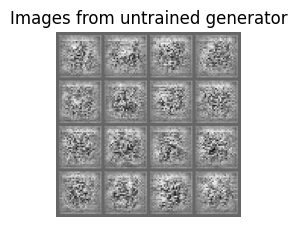

In [9]:
# Create the generator.
netG = Generator().to(device)

# Example execution.
fixed_batch_size = 16
fixed_noise = torch.randn(fixed_batch_size, nz, 1, 1, device=device)
fixed_y = torch.randint(low=0, high=10, size=(fixed_batch_size, 1), device=device)
example_generations = netG(fixed_noise, fixed_y)
print(example_generations.shape)
plot_images(example_generations, "Images from untrained generator")

## Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.embedding = nn.Embedding(10, 49)
        self.linear = nn.Linear(49, 28 * 28)
        self.convolutions = nn.Sequential(
            nn.Conv2d(
                in_channels=2,
                out_channels=16,
                kernel_size=(3, 3),
                padding=1,
                stride=1,
                bias=False,
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=(4, 4),
                padding=1,
                stride=2,
                bias=False,),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=(4, 4),
                padding=1,
                stride=2,
                bias=False,),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(7, 7),
                padding=0,
                stride=1,
                bias=False,),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
        )

        self.output = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Args:
          x: image to be discriminated, shape (B, 1, 28, 28)
          y: purported label, shape (B, 1)

        Returns: probability of x being a true image for label y, shape (B, 1).
        """
        y = self.embedding(y).squeeze()  # (B, 1) -> (B, 1, E)
        y = self.linear(y)
        y = F.leaky_relu(y)  # (B, 1, 28 * 28)
        y = y.view([-1, 1, 28, 28]) # (B, 1, 28, 28)

        x = torch.cat([x, y], dim=1)  # (B, 1 + 1, 28, 28)
        x = self.convolutions(x)  # (B, 128, 1, 1)
        x = x.view(-1, 128)  # (B, 128)
        x = self.output(x) # (B, 1)
        return x

In [11]:
# Create the Discriminator.
netD = Discriminator().to(device)

# Example execution.
netD(example_generations, fixed_y)

tensor([[0.4058],
        [0.4736],
        [0.3696],
        [0.5472],
        [0.5715],
        [0.4509],
        [0.4188],
        [0.4436],
        [0.3663],
        [0.5256],
        [0.5597],
        [0.4445],
        [0.5078],
        [0.4241],
        [0.5342],
        [0.3685]], device='cuda:0', grad_fn=<SigmoidBackward0>)

## Training

In [12]:
# Initialize the BCELoss function.
criterion = nn.BCELoss()

# Create a fixed batch of latent vectors, which we will use to visualize
#  how the generator progresses.
fixed_batch_size = 64
fixed_noise = torch.randn(fixed_batch_size, nz, 1, 1, device=device)
fixed_y = torch.randint(low=0, high=10, size=(fixed_batch_size, 1), device=device)

# Establish convention for real and fake labels during training.
REAL_LABEL = 1.0
FAKE_LABEL = 0.0

# Setup Adam optimizers for both G and D.
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
# Training Loop (takes ~30s per epoch on Colab with GPU).

# Lists to keep track of progress
img_list: list[torch.Tensor] = []
G_losses: list[float] = []
D_losses: list[float] = []
iters: int = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}")
    for i, (real_images, real_y_labels) in pbar:

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        optimizerG.zero_grad()
        optimizerD.zero_grad()

        # Format all-real batch.
        real_images = real_images.to(device)
        real_y_labels = real_y_labels.to(device)
        b_size = real_images.shape[0]
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Forward pass of real batch through D.
        output = netD(real_images, real_y_labels).view(-1)
        D_x = output.mean().item()
        # Calculate loss on all-real batch.
        errD_real = criterion(output, label)

        # Generate batch of latent vectors for all-fake batch.
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        noise_y = torch.randint(low=0, high=10, size=(b_size, 1), device=device)
        # Generate fake image batch with G.
        fake = netG(noise, noise_y)
        label = torch.full((b_size,), FAKE_LABEL, dtype=torch.float, device=device)
        # Classify all-fake batch with D.
        output = netD(fake.detach(), noise_y.detach()).view(-1)
        D_G_z1 = output.mean().item()
        # Calculate D's loss on the all-fake batch.
        errD_fake = criterion(output, label)

        # Add the gradients from the all-real and all-fake batches.
        errD = (errD_real + errD_fake) / 2
        # Calculate the gradients for this batch.
        errD.backward()
        # Update D.
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizerD.zero_grad()
        optimizerG.zero_grad()

        # Since we just updated D, we'll perform another forward pass through D.
        # Prepare all-fake batch.
        noise = torch.randn(2 * b_size, nz, 1, 1, device=device)
        noise_y = torch.randint(low=0, high=10, size=(2 * b_size, 1), device=device)
        fake = netG(noise, noise_y)
        label = torch.full((2 * b_size,), REAL_LABEL, dtype=torch.float, device=device)

        output = netD(fake, noise_y).view(-1)
        D_G_z2 = output.mean().item()
        # Calculate G's loss based on this output.
        errG = criterion(output, label)
        # Calculate gradients for G.
        errG.backward()
        # Update G.
        optimizerG.step()

        # Output training stats.
        if i % 250 == 0:
            tqdm.write(
                f"\n[{epoch}/{num_epochs}][{i:3}/{len(dataloader)}]\t"
                + f"Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\t"
                + f"D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}"
            )

        # Save losses for plotting later.
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise.
        if (iters % 500 == 0) or (i == len(dataloader) - 1):
            netG.eval()
            with torch.no_grad():
                img_list.append(
                    netG(fixed_noise, fixed_y).detach().cpu()
                )
            netG.train()

        iters += 1

Starting Training Loop...


Epoch 0:   0%|          | 2/469 [00:00<01:55,  4.03it/s]


[0/10][  0/469]	Loss_D: 0.7081	Loss_G: 0.7803	D(x): 0.4616	D(G(z)): 0.4611 / 0.4636


Epoch 0:  54%|█████▎    | 252/469 [00:19<00:15, 14.07it/s]


[0/10][250/469]	Loss_D: 0.4711	Loss_G: 1.1054	D(x): 0.6006	D(G(z)): 0.3378 / 0.3377


Epoch 1:   1%|          | 3/469 [00:00<00:37, 12.29it/s]


[1/10][  0/469]	Loss_D: 0.5100	Loss_G: 1.0000	D(x): 0.5832	D(G(z)): 0.3641 / 0.3822


Epoch 1:  54%|█████▍    | 253/469 [00:15<00:15, 13.70it/s]


[1/10][250/469]	Loss_D: 0.4464	Loss_G: 1.2180	D(x): 0.6131	D(G(z)): 0.3118 / 0.3080


Epoch 2:   1%|          | 3/469 [00:00<00:43, 10.66it/s]


[2/10][  0/469]	Loss_D: 0.4049	Loss_G: 1.4876	D(x): 0.7378	D(G(z)): 0.3702 / 0.2543


Epoch 2:  54%|█████▍    | 253/469 [00:15<00:15, 14.39it/s]


[2/10][250/469]	Loss_D: 0.3626	Loss_G: 1.6275	D(x): 0.7095	D(G(z)): 0.2867 / 0.2169


Epoch 3:   1%|          | 3/469 [00:00<00:32, 14.29it/s]


[3/10][  0/469]	Loss_D: 0.3252	Loss_G: 1.7411	D(x): 0.7385	D(G(z)): 0.2507 / 0.1998


Epoch 3:  54%|█████▍    | 253/469 [00:15<00:14, 14.47it/s]


[3/10][250/469]	Loss_D: 0.3083	Loss_G: 1.7490	D(x): 0.7323	D(G(z)): 0.2337 / 0.2122


Epoch 4:   1%|          | 4/469 [00:00<00:32, 14.36it/s]


[4/10][  0/469]	Loss_D: 0.2889	Loss_G: 1.6496	D(x): 0.7858	D(G(z)): 0.2530 / 0.2252


Epoch 4:  54%|█████▎    | 252/469 [00:16<00:14, 14.53it/s]


[4/10][250/469]	Loss_D: 0.2459	Loss_G: 1.9572	D(x): 0.7958	D(G(z)): 0.2075 / 0.1897


Epoch 5:   1%|          | 3/469 [00:00<00:33, 13.73it/s]


[5/10][  0/469]	Loss_D: 0.2851	Loss_G: 2.0975	D(x): 0.7801	D(G(z)): 0.2253 / 0.1527


Epoch 5:  54%|█████▍    | 253/469 [00:15<00:12, 16.74it/s]


[5/10][250/469]	Loss_D: 0.3546	Loss_G: 2.0664	D(x): 0.8370	D(G(z)): 0.3624 / 0.1862


Epoch 6:   1%|          | 3/469 [00:00<00:36, 12.91it/s]


[6/10][  0/469]	Loss_D: 0.2743	Loss_G: 2.5068	D(x): 0.8429	D(G(z)): 0.2657 / 0.1196


Epoch 6:  54%|█████▍    | 253/469 [00:15<00:12, 16.71it/s]


[6/10][250/469]	Loss_D: 0.2099	Loss_G: 2.1708	D(x): 0.8207	D(G(z)): 0.1762 / 0.1489


Epoch 7:   1%|          | 3/469 [00:00<00:37, 12.45it/s]


[7/10][  0/469]	Loss_D: 0.2314	Loss_G: 2.4909	D(x): 0.8361	D(G(z)): 0.2121 / 0.1331


Epoch 7:  54%|█████▍    | 253/469 [00:15<00:12, 17.02it/s]


[7/10][250/469]	Loss_D: 0.1913	Loss_G: 2.1761	D(x): 0.8218	D(G(z)): 0.1378 / 0.1527


Epoch 8:   1%|          | 3/469 [00:00<00:34, 13.53it/s]


[8/10][  0/469]	Loss_D: 0.2544	Loss_G: 2.3199	D(x): 0.8116	D(G(z)): 0.2105 / 0.1602


Epoch 8:  54%|█████▍    | 253/469 [00:15<00:13, 16.27it/s]


[8/10][250/469]	Loss_D: 0.2021	Loss_G: 2.2662	D(x): 0.8031	D(G(z)): 0.1292 / 0.1704


Epoch 9:   1%|          | 3/469 [00:00<00:37, 12.29it/s]


[9/10][  0/469]	Loss_D: 0.2745	Loss_G: 3.0559	D(x): 0.8260	D(G(z)): 0.2425 / 0.0996


Epoch 9:  54%|█████▎    | 251/469 [00:18<00:20, 10.53it/s]


[9/10][250/469]	Loss_D: 0.1277	Loss_G: 2.4560	D(x): 0.8791	D(G(z)): 0.1079 / 0.1395


Epoch 9: 100%|██████████| 469/469 [00:32<00:00, 14.46it/s]


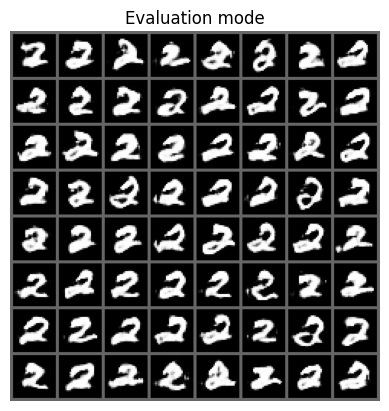

In [14]:
netG.zero_grad()
netG.eval()

generated_label = 2

test_noise = torch.randn(64, nz, 1, 1, device=device)
test_y = torch.full(size=(64, 1), fill_value=generated_label, device=device)

plot_images(netG(test_noise, test_y).detach().cpu(), "Evaluation mode")

In [15]:
#%%capture

def show_images_animation(image_batch_list: list[torch.Tensor], title: str, scale: float = 0.6):
    """Show a batch of images as a grid."""
    n_images = len(image_batch_list[0])
    n_columns = int(np.ceil(np.sqrt(n_images)))
    n_rows = int(np.ceil(n_images / n_columns))
    fig = plt.figure(figsize=(n_columns * scale, n_rows * scale))
    plt.axis("off")
    plt.title(title)
    grids = [[plt.imshow(
        np.transpose(
            vutils.make_grid(
                img, nrow=n_columns, padding=2, pad_value=0.4, normalize=True
            ).cpu(),
            (1, 2, 0),
        ),
        animated=True
    )] for img in image_batch_list]
    ani = animation.ArtistAnimation(fig, grids, interval=1000, repeat_delay=1000, blit=True)
    plt.close()
    return HTML(ani.to_jshtml())

show_images_animation(img_list, "Generation progress during training (fixed z)")

## Interpolation

In [16]:
# #########################################################
#                    To implement
# #########################################################